This example script combined the reported data (UN Comtrade) and estimated data (Trade Matrix) to show bilateral flows

In [43]:
import comtradeapicall
import os
from dotenv import load_dotenv
load_dotenv()
subscription_key = os.getenv("SUBSCRIPTION_KEY")
# get the list of standard groups from https://comtradeapi.un.org/files/v1/app/reference/country_groups.json
# this is example for SCO
reporterCode = '156,356,398,417,586,643,762,860,699'

Get bilateral data of commodity TOTAL in 2024 in exports and imports

In [45]:
# Get data from Comtrade Final Data and Trade Matrix
dfFinalData = comtradeapicall.getFinalData(subscription_key, typeCode='C', freqCode='A', clCode='SS', period='2024', reporterCode=reporterCode,
                                           cmdCode='TOTAL', flowCode='X,M', partnerCode=reporterCode, partner2Code='0', customsCode='C00', motCode='0', breakdownMode='classic', aggregateBy=None, includeDesc=True)
dfTradeMatrix = comtradeapicall.getTradeMatrix(subscription_key, typeCode='C', freqCode='A', period='2024', reporterCode=reporterCode,
                                               cmdCode='TOTAL', flowCode='X,M', partnerCode=reporterCode, aggregateBy=None, includeDesc=True)

Combine the data frame from UN Comtrade (reported) and Trade Matrix (estimated)

In [46]:
import pandas as pd

# --- Ensure period is comparable across both frames (e.g., convert to string) ---
for df in (dfFinalData, dfTradeMatrix):
    if 'period' in df.columns:
        df['period'] = df['period'].astype(str)

# --- Define the columns we care about ---
cols = ['reporterDesc', 'partnerDesc', 'flowCode', 'period', 'primaryValue']

# Optional: restrict to the listed columns in case either DF has extra columns
dfFinalData_use = dfFinalData[cols].copy()
dfTradeMatrix_use = dfTradeMatrix[cols].copy()

# --- Build a compound key for matching combinations of reporterDesc+period ---
key_cols = ['reporterDesc', 'period']
dfFinalData_use['_key'] = dfFinalData_use[key_cols].agg('||'.join, axis=1)
dfTradeMatrix_use['_key'] = dfTradeMatrix_use[key_cols].agg('||'.join, axis=1)

# --- Identify keys present in dfFinalData ---
final_keys = set(dfFinalData_use['_key'])

# --- Filter dfTradeMatrix rows where (reporterDesc, period) are NOT in dfFinalData ---
dfTrade_missing = dfTradeMatrix_use[~dfTradeMatrix_use['_key'].isin(
    final_keys)].copy()

# --- Add estimation flag ---
dfFinalData_use['estimation'] = False
dfTrade_missing['estimation'] = True

# --- Combine, drop helper key, and ensure final column order ---
dfCombined = (
    pd.concat([dfFinalData_use, dfTrade_missing], ignore_index=True)
      .drop(columns=['_key'])
)

# Optional: sort for readability (first by reporterDesc, then period, then estimation)
dfCombined = dfCombined.sort_values(
    by=['reporterDesc', 'period', 'estimation']).reset_index(drop=True)

# dfCombined now contains:
# - all rows from dfFinalData (authoritative, estimation=False)
# - plus any missing (reporterDesc, period) combos from dfTradeMatrix (estimation=True)

Create a pivot table

In [47]:
# make pivot table

# --- Make sure types are consistent and estimation is boolean ---
dfCombined['period'] = dfCombined['period'].astype(str)
dfCombined['estimation'] = dfCombined['estimation'].astype(bool)

# --- Build the pivot ---
dfPivot = pd.pivot_table(
    dfCombined,
    index=['period', 'flowCode', 'reporterDesc'],     # row hierarchy
    columns='partnerDesc',                            # columns
    values=['primaryValue', 'estimation'],            # measures
    aggfunc={'primaryValue': 'sum', 'estimation': 'max'},
    # fill missing with 0 for sums; max(False)=False
    fill_value=0,
    # include all categories if categoricals present
    observed=False
)

# --- Optional: sort for readability ---
dfPivot = dfPivot.sort_index(axis=0).sort_index(axis=1)

# --- Optional: flatten the multi-level columns for easier export/use ---
# e.g., columns like 'primaryValue|United States', 'estimation|United States'
dfPivot_flat = dfPivot.copy()
dfPivot_flat.columns = [
    f"{metric}|{partner}" for metric, partner in dfPivot_flat.columns]

# At this point:
# - dfPivot is a MultiIndex columns DataFrame with two metrics across partnerDesc
# - dfPivot_flat has single-level columns, helpful for Excel/CSV export

Save to file (excel)

In [51]:
# Ensure types are consistent
dfCombined['period'] = dfCombined['period'].astype(str)
dfCombined['estimation'] = dfCombined['estimation'].astype(bool)

# Build the pivot per your rules:
# Rows: period -> flowCode -> reporterDesc
# Columns: partnerDesc
# Measures: sum(primaryValue), max(estimation)
dfPivot = pd.pivot_table(
    dfCombined,
    index=['period', 'flowCode', 'reporterDesc'],
    columns='partnerDesc',
    values=['primaryValue', 'estimation'],
    aggfunc={'primaryValue': 'sum', 'estimation': 'max'},
    fill_value=0,
    observed=False
).sort_index(axis=0).sort_index(axis=1)

# Optional: Flatten columns for a simpler Excel sheet
# This will create columns like "primaryValue|United States", "estimation|United States"
dfPivot_flat = dfPivot.copy()
dfPivot_flat.columns = [
    f"{metric}|{partner}" for metric, partner in dfPivot_flat.columns]

# If you’d like estimation as 0/1 in the flattened sheet:
if any(col.startswith('estimation|') for col in dfPivot_flat.columns):
    est_cols = [c for c in dfPivot_flat.columns if c.startswith('estimation|')]
    dfPivot_flat[est_cols] = dfPivot_flat[est_cols].astype(bool).astype(int)

# --- Export to Excel ---
out_path = "trade_bilateral.xlsx"
with pd.ExcelWriter(out_path, engine="openpyxl") as writer:
    # Multi-index version (keeps the two metrics as a column level)
    # merge_cells=False avoids Excel merging header cells, making filtering easier
    dfPivot.to_excel(writer, sheet_name="PivotMulti", merge_cells=False)

    # Flattened version (single-level columns)
    dfPivot_flat.to_excel(writer, sheet_name="PivotFlat")

print(f"Excel file written to: {out_path}")

Excel file written to: trade_bilateral.xlsx


Show as graph

PNG saved: sankey_bilateral.png


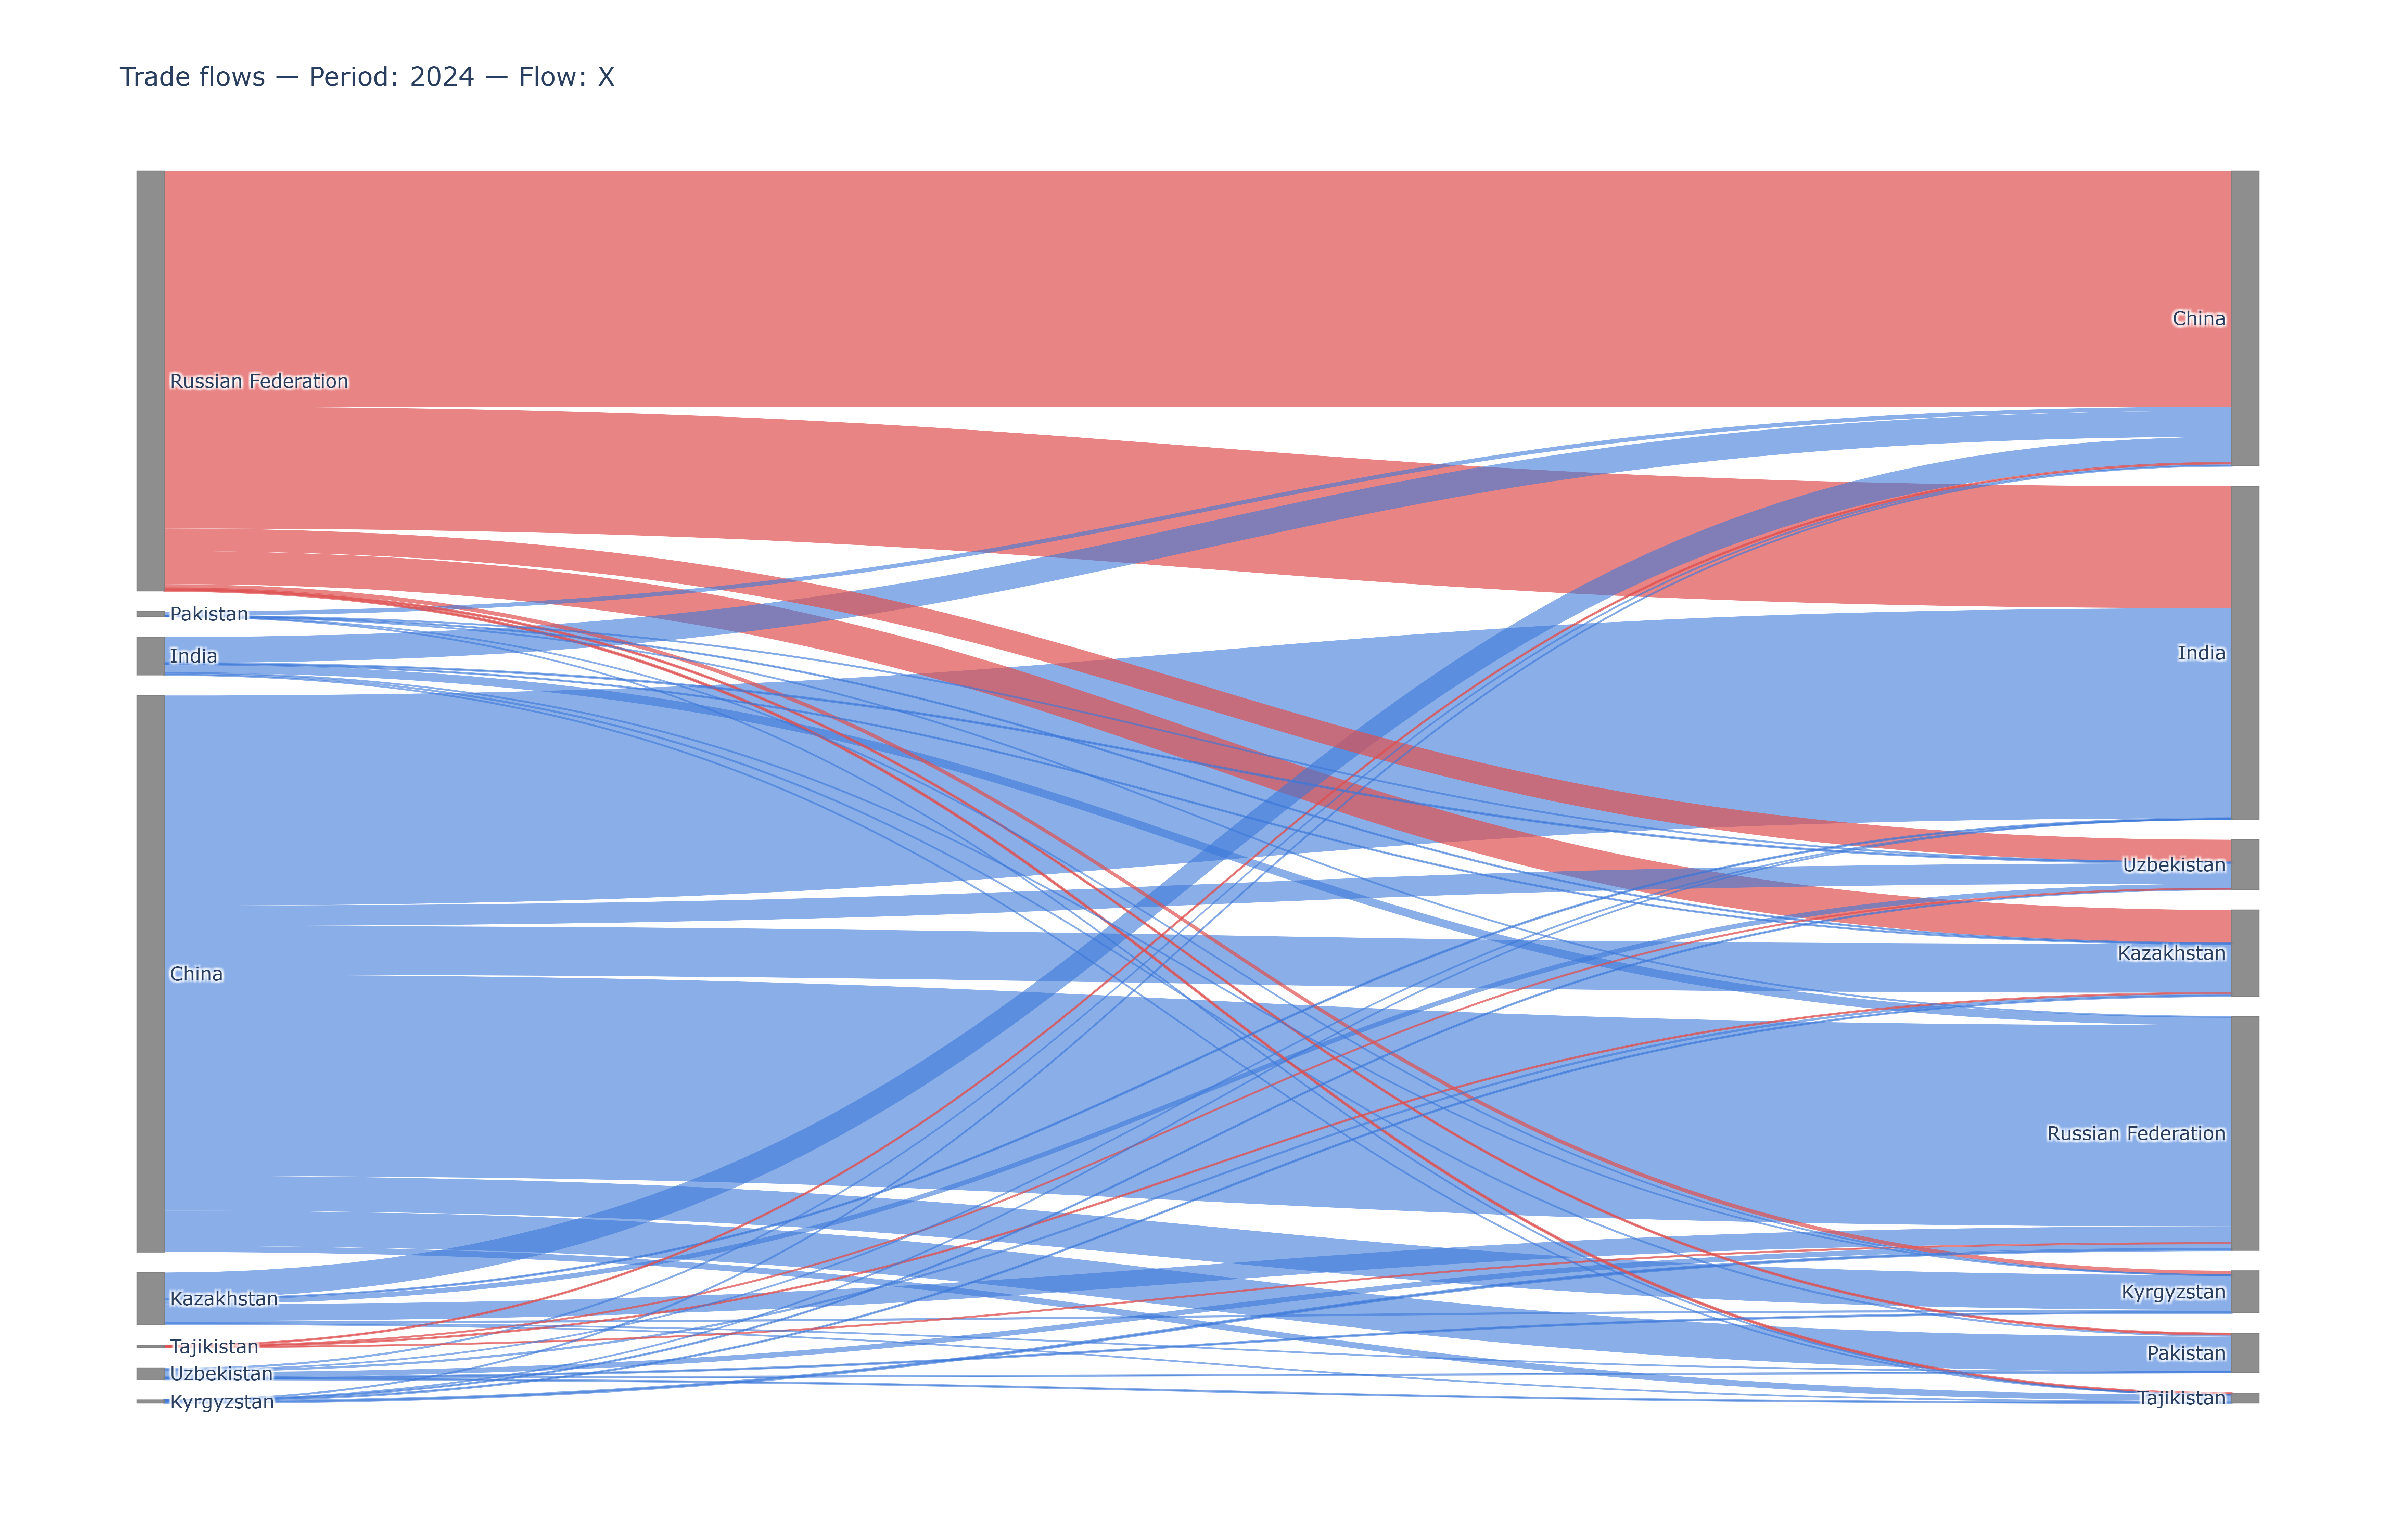

In [ ]:
# =========================
# Sankey / Heatmap Visualization + Save to PNG
# =========================

from IPython.display import Image, display
import pandas as pd
import numpy as np

# ---------- Ensure consistent dtypes ----------
dfCombined['period'] = dfCombined['period'].astype(str)
dfCombined['estimation'] = dfCombined['estimation'].astype(bool)

# ---------- Helper: aggregate to edges (reporter -> partner) ----------


def prepare_edges(df, period=None, flowCode=None, top_n_links=50):
    """
    Returns an aggregated edge table:
      columns: reporterDesc, partnerDesc, primaryValue (sum), estimation (max)
    Filtering by period and flowCode is optional. Keeps only the top N links by value.
    """
    mask = pd.Series(True, index=df.index)
    if period is not None:
        if isinstance(period, (list, tuple, set, pd.Series, np.ndarray)):
            period = [str(p) for p in period]
        else:
            period = [str(period)]
        mask &= df['period'].isin(period)
    if flowCode is not None:
        if isinstance(flowCode, (list, tuple, set, pd.Series, np.ndarray)):
            fc = list(flowCode)
        else:
            fc = [flowCode]
        mask &= df['flowCode'].isin(fc)

    dff = df.loc[mask, ['reporterDesc', 'partnerDesc',
                        'primaryValue', 'estimation']].copy()
    if dff.empty:
        raise ValueError(
            "No data after filtering. Check your period/flowCode filters.")

    edges = (dff
             .groupby(['reporterDesc', 'partnerDesc'], as_index=False)
             .agg(primaryValue=('primaryValue', 'sum'),
                  estimation=('estimation', 'max'))
             )

    # Keep strongest links for readability
    if top_n_links is not None and top_n_links > 0 and len(edges) > top_n_links:
        edges = edges.sort_values(
            'primaryValue', ascending=False).head(top_n_links).copy()

    return edges

# ---------- Plotly Sankey (No HTML saving) ----------


def plot_sankey_plotly(edges, title="Sankey"):
    """
    Build a Sankey using Plotly, render to screen using a non-MIME renderer (browser).
    Does NOT write or save any HTML file.
    """
    try:
        import plotly.graph_objects as go
        import plotly.io as pio
    except Exception as e:
        raise ImportError(
            "Plotly is not available. Use the heatmap fallback instead.") from e

    # Force Plotly to use a renderer that doesn't rely on nbformat inline MIME
    pio.renderers.default = "browser"

    # Create node lists
    reporters = edges['reporterDesc'].unique().tolist()
    partners = edges['partnerDesc'].unique().tolist()
    labels = reporters + partners

    reporter_index = {r: i for i, r in enumerate(reporters)}
    partner_index = {p: len(reporters) + j for j, p in enumerate(partners)}

    source = edges['reporterDesc'].map(reporter_index).to_list()
    target = edges['partnerDesc'].map(partner_index).to_list()
    value = edges['primaryValue'].astype(float).to_list()

    # Color links: estimated (red), otherwise blue
    link_color = ['rgba(222,80,80,0.70)' if est else 'rgba(60,120,216,0.60)'
                  for est in edges['estimation']]

    fig = go.Figure(data=[go.Sankey(
        arrangement="snap",
        node=dict(
            pad=12,
            thickness=16,
            line=dict(color="gray", width=0.5),
            label=labels,
            color=["rgba(130,130,130,0.9)"] * len(labels)
        ),
        link=dict(
            source=source,
            target=target,
            value=value,
            color=link_color,
            hovertemplate="<b>%{source.label} → %{target.label}</b><br>"
                          "Value: %{value:,.0f}<extra></extra>"
        )
    )])

    fig.update_layout(
        title=title,
        font=dict(size=11),
        height=max(500, 25 * max(len(reporters), len(partners)))
    )
    return fig

# ---------- Save Plotly figure to PNG via Kaleido ----------


def save_plotly_png(fig, png_path="sankey.png", scale=2, width=None, height=None):
    """
    Saves a Plotly figure as PNG using Kaleido.
    If Kaleido is not installed, raises an informative error.
    """
    try:
        # This import is not strictly required to call write_image,
        # but it helps detect whether kaleido is available in the environment.
        import kaleido  # noqa: F401
    except Exception as e:
        raise RuntimeError(
            "Kaleido is required to save Plotly figures to PNG.\n"
            "Install it in the SAME Python environment your kernel uses:\n"
            "    pip install kaleido\n"
            "Then re-run this cell."
        ) from e

    # Write the PNG
    fig.write_image(png_path, scale=scale, width=width, height=height)
    print(f"PNG saved: {png_path}")

# ---------- Matplotlib heatmap fallback ----------


def plot_heatmap_matplotlib(edges, title="Heatmap", save_png_path=None):
    """
    Build a reporter x partner heatmap of primaryValue with red markers where estimation=True.
    Shows on screen via plt.show(). If save_png_path is provided, saves to a PNG file too.
    """
    import matplotlib.pyplot as plt

    mat = edges.pivot_table(index='reporterDesc', columns='partnerDesc',
                            values='primaryValue', aggfunc='sum', fill_value=0)
    est = edges.pivot_table(index='reporterDesc', columns='partnerDesc',
                            values='estimation', aggfunc='max', fill_value=False)

    # Ensure aligned
    est = est.reindex(index=mat.index, columns=mat.columns, fill_value=False)

    # Figure sizing based on matrix size
    fig_w = max(8, mat.shape[1] * 0.4)
    fig_h = max(6, mat.shape[0] * 0.4)
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))

    im = ax.imshow(mat.values, aspect='auto', cmap='Blues')
    ax.set_xticks(range(mat.shape[1]))
    ax.set_yticks(range(mat.shape[0]))
    ax.set_xticklabels(mat.columns, rotation=45, ha='right')
    ax.set_yticklabels(mat.index)
    ax.set_xlabel("partnerDesc")
    ax.set_ylabel("reporterDesc")
    ax.set_title(title)

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("Sum of primaryValue")

    # Overlay red squares where estimation=True
    yy, xx = np.where(est.values)
    if len(xx) > 0:
        ax.scatter(xx, yy, s=30, c='red', marker='s', label='Has estimation')
        ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0))

    plt.tight_layout()

    if save_png_path:
        fig.savefig(save_png_path, dpi=150, bbox_inches="tight")
        print(f"PNG saved: {save_png_path}")

    plt.show()
    return fig, ax

# ---------- Convenience wrapper: visualize and save to PNG ----------


def visualize_and_save_png(df, period=None, flowCode=None, top_n_links=50,
                           title_prefix="Trade flows", png_path="sankey.png",
                           scale=2, width=None, height=None):
    """
    Tries Plotly Sankey: shows in browser and saves PNG via Kaleido.
    If Plotly/Kaleido unavailable, falls back to Matplotlib heatmap and saves PNG via plt.
    """
    edges = prepare_edges(
        df, period=period, flowCode=flowCode, top_n_links=top_n_links)

    # Title context
    period_txt = (",".join(period) if isinstance(
        period, (list, tuple, set)) else str(period)) if period else "All"
    flow_txt = (",".join(flowCode) if isinstance(
        flowCode, (list, tuple, set)) else str(flowCode)) if flowCode else "All"
    title = f"{title_prefix} — Period: {period_txt} — Flow: {flow_txt}"

    try:
        fig = plot_sankey_plotly(edges, title=title)
        # Save to PNG via Kaleido
        save_plotly_png(fig, png_path=png_path, scale=scale,
                        width=width, height=height)
        return {"type": "sankey", "edges": edges, "fig": fig, "png": png_path}
    except ImportError:
        print("Plotly not available. Rendering heatmap instead.")
        fig, ax = plot_heatmap_matplotlib(
            edges, title=title, save_png_path=png_path)
        return {"type": "heatmap", "edges": edges, "fig": fig, "png": png_path}
    except RuntimeError as e:
        # Kaleido missing: still show Sankey, but save via heatmap fallback
        print(str(e))
        print("Saving a heatmap PNG instead.")
        fig, ax = plot_heatmap_matplotlib(
            edges, title=title, save_png_path=png_path)
        return {"type": "sankey_shown_heatmap_saved", "edges": edges, "fig": fig, "png": png_path}


# ---------- Example usages ----------
# 1) Create and save the PNG (Sankey via Plotly + Kaleido; fallback to heatmap)
result = visualize_and_save_png(
    dfCombined,
    period='2024',            # e.g., '2024' or None
    flowCode='X',             # 'I' imports / 'E' exports / None
    top_n_links=50,
    png_path='sankey_bilateral.png',
    scale=5,                  # increase for crisper image
    width=1400, height=900    # optional explicit size
)

# 2) Display inline in VS Code Jupyter
display(Image(filename=result['png']))